# Trying out fitting a K2 transit of K2-9b (or EPIC 201465501) with Everest and MCMC


In [1]:
import everest
import numpy as np
import matplotlib.pyplot as pl
%matplotlib inline
import sys
sys.path.append("../src/")

import everestmod
import astropy

In [3]:
star = everestmod.EverestMOD(201465501)

INFO  [everest.user.DownloadFile()]: Found cached file.
INFO  [everest.user.load_fits()]: Loading FITS file for 201465501.


INFO  [everest.user.plot()]: Plotting the light curve...


/Users/gks/anaconda/lib/python2.7/site-packages/scipy/linalg/basic.py:1018: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


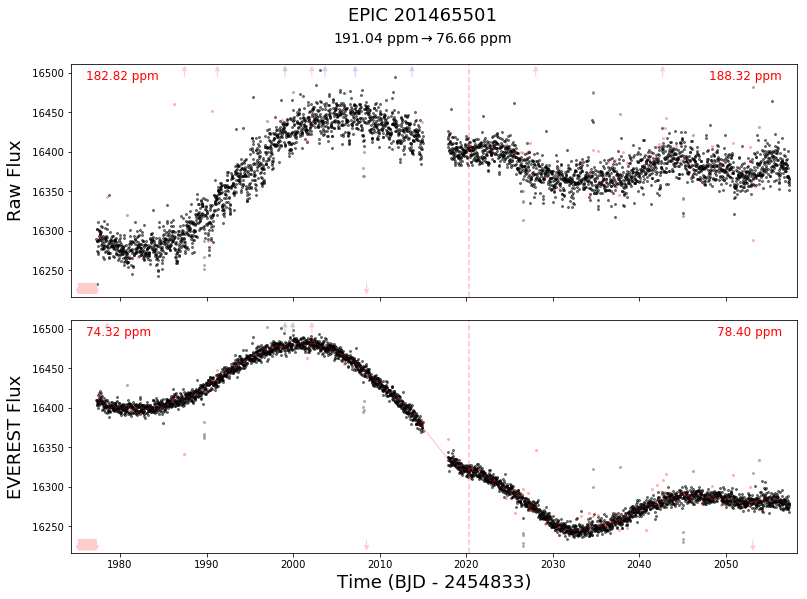

In [4]:
star.plot()

##### This epic target has known planet parameters from Crossfield et al. 2016

<img src="epic_table.png">

## Plot folded transit using Everest
This does not give us access to the flux arrays for some reason

INFO  [everest.basecamp.compute()]: Computing the model...


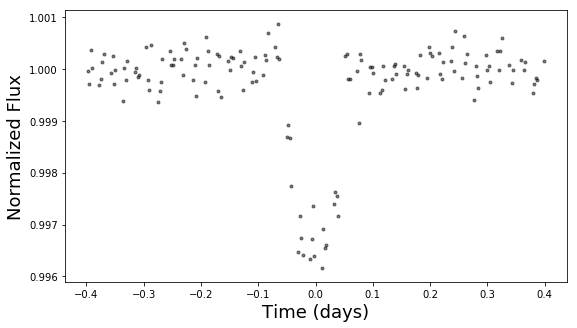

In [5]:
t0      = 1989.6744
t0_err  = 0.028
per     = 18.4474
per_err = 0.0015
star.mask_planet(t0,per)
star.compute()
star.plot_folded(t0,per)

#### Use everestmod to get access to the folded flux arrays

INFO  [everest.basecamp.compute()]: Computing the model...


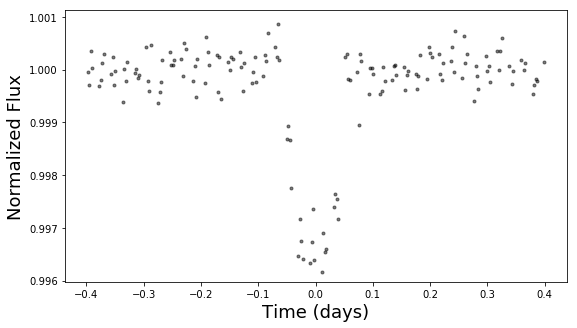

In [6]:
star.mask_planet(t0,per)
star.compute()
time, flux = star.get_folded_transit(t0,per,plot=True)

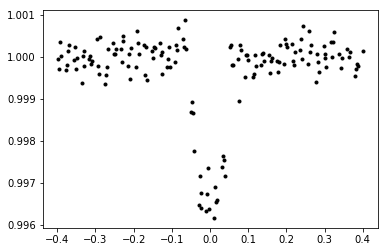

In [7]:
# Plot by hand
pl.plot(time,flux,"k.")

# Fitting with MCMC

In [8]:
import tf
from priors import PriorSet, UP, NP, JP
import batman
import pyde
import math
from exotk.utils.likelihood import ll_normal_ev_py, ll_normal_es_py, ll_normal_es, ll_normal_ev
from scipy.optimize import minimize
import IPython
import ipywidgets
from IPython.display import display
from IPython.display import HTML
import corner
import emcee
import mcFunc

In [16]:
class LPFunction(object):
    """
    Log-Likelihood function class
    
    General philosophy:
    — Modify this for each fit
    — Outputs will be passed to emcee.sampler()
    — Outside of this are functions to plot the MCMC chains and corner plots
       
    NOTES:
    Based on hpprvi's awesome class, see: https://github.com/hpparvi/exo_tutorials
    
    I extended the Prior and Priorset classes in 
    /Users/gks/.local/lib/python2.7/site-packages/exotk
    """
    def __init__(self,number_pv_baseline=7,convergence_diagnostics=False):
        """
        Note: number_pv_baseline must be set to whatever the index of the 'fraw' parameter is
        """
        # This is only performed during initialization
        self.convergence_diagnostics = convergence_diagnostics
        self.number_pv_baseline = number_pv_baseline
                
        self.data= {"time"   : time, # phase folded time in days (centered on 0)
                    "flux"   : flux, # phase folded flux
                    "error"  : 1e-5, # asssumed fixed errorbar
                    }
        
        #####
        # Setting priors
        self.priors = [UP( -0.01               , 0.01                   , 'tc'       ,r'$T_C$'                 ,priortype="model"),  ##   0 - Transit centre, Tc
                       NP( 1.2659351647919772  , 0.001                  , 'logP'     ,r'$\log(P)$'             ,priortype="model"),  ##   1 - log(P)
                       UP( 0.                  , 0.034                  , 'cos(i)'   ,r'$\cos(i)$'             ,priortype="model"),  ##   2 - cos(i)
                       UP( 0.04                , 0.07                   , 'RpRs'     ,r'$R_p/R_s$'             ,priortype="model"),  ##   3 - rp/rstar
                       UP( 1.3                 , 1.7                    , 'log(a/Rs)',r'$\log(a/R_s)$'         ,priortype="model"),  ##   4 - log(a/rstar)     
                       UP( 0.                  , 1.                     , 'q1'       ,r'$q_1$'                 ,priortype="model"),  ##   5 - q1
                       UP( 0.                  , 1.                     , 'q2'       ,r'$q_2$'                 ,priortype="model"),  ##   6 - q2
                       UP( 0.9                 , 1.1                    , 'fraw'     ,r'fraw'                  ,priortype="model")]  ##   7 - Baseline constant
        
        # If we want to fix limb-dark parameters
        # self.limbdark = [ 0.16689202, 0.44493439] 
        self.ps     = PriorSet(self.priors)
        if self.convergence_diagnostics:
            self.maxiter     = 10000
            self.df_minimize = pd.DataFrame(index=range(self.maxiter),columns=self.ps.names+["log_ln"])
            self.index       = 0
        
    def compute_transit(self,pv,times=None):
        """
        Calls BATMAN and returns the transit model
        
        INPUT:
        pv    - parameters passed to the function 
        times - times, and array of timestamps 
        
        OUTPUT:
        lc - the lightcurve model at *times*
        """
        self.params = batman.TransitParams
        self.params.t0 = pv[0]
        self.params.per = 10.**pv[1]
        self.params.inc = np.arccos(pv[2])*180./math.pi
        self.params.rp = pv[3]
        self.params.a = 10.**pv[4]
        
        self.params.ecc = 0.
        self.params.w = 0.
        q1, q2 = pv[5], pv[6]
        self.params.u = mcFunc.u1_u2_from_q1_q2(q1,q2) # Kipping 2013 formalism
        #self.params.u = self.limbdark
        self.params.limb_dark = "quadratic"
        self.params.fp = 0.001
        if times==None:
            times = self.data["time"]        
        transitmodel = batman.TransitModel(self.params, times, transittype='primary')
        self.lc = transitmodel.light_curve(self.params)
        return self.lc        
    
    def detrend(self,pv):
        """
        A function to detrend.
        
        INPUT:
        pv    - an array containing a sample draw of the parameters defined in self.lpf.ps
        
        OUTPUT:
        detrend/pv[self.number_pv_baseline] - the additional trend in the data (no including transit)
        """
        detrend = np.zeros(len(self.data["flux"]))
        
        # loop over detrend parameters
        for i in self.ps.get_param_type_indices(paramtype="detrend"):
            #print(i)
            detrend += pv[i]*(self.data[self.ps.labels[i]]-1.)
        return detrend/pv[self.number_pv_baseline]
        
    def compute_lc_model(self,pv):
        """
        Compute the light curve model with detrend
        
        INPUT:
        pv - an array containing a sample draw of the parameters defined in self.lpf.ps
        
        OUTPUT:
        The full light curve model with a trend
        
        TODO:
        - Choose to use GPs ?
        """
        return self.compute_transit(pv) + self.detrend(pv)
    
                    
    def __call__(self,pv):
        """
        Return the log likelihood
        
        NOTES:
        This is done each time an instance is called
        """
        # If priors are outside of bounds, return -inf
        #if all(pv > self.ps.pmins) and all(pv<self.ps.pmaxs):
            #print("within bounds")
        if any(pv < self.ps.pmins) or any(pv>self.ps.pmaxs):
            #print("out of bounds")
            #print("Too low:",np.array(self.ps.names)[pv<self.ps.pmins])
            #print("Too high:",np.array(self.ps.names)[pv>self.ps.pmaxs],np.array(pv)[pv>self.ps.pmaxs])
            return -np.inf
        # make sure that sqrtecosw is well behaved
        flux_m = self.compute_lc_model(pv)
        
        # Return the log-likelihood
        log_of_priors = self.ps.c_log_prior(pv)
        scaled_flux   = self.data["flux"]/pv[self.number_pv_baseline]
        log_of_model  = ll_normal_es_py(scaled_flux, flux_m, self.data["error"])
        
        log_ln = log_of_priors + log_of_model
        
        if self.convergence_diagnostics==True:
            self.df_minimize.loc[self.index] = np.hstack([pv,log_ln])
            self.index += 1
        return log_ln

In [17]:
# Initialize an instance of the Transit Fitter Class, using the LPFunction as defined above
TF = tf.TransitFit(LPFunction,convergence_diagnostics=False)

Running PyDE Optimizer
Optimized using PyDE
('Final parameters:', array([ -1.54524513e-03,   1.26393985e+00,   2.14466769e-02,
         5.97397579e-02,   1.56819561e+00,   6.94607408e-01,
         2.40319013e-01,   1.00001511e+00]))
('LogLn value:', 75190.439661403027)
('Log priors', 17.323889211479941)
Running MCMC
Finished MCMC
Plotting MCMC optimized transit


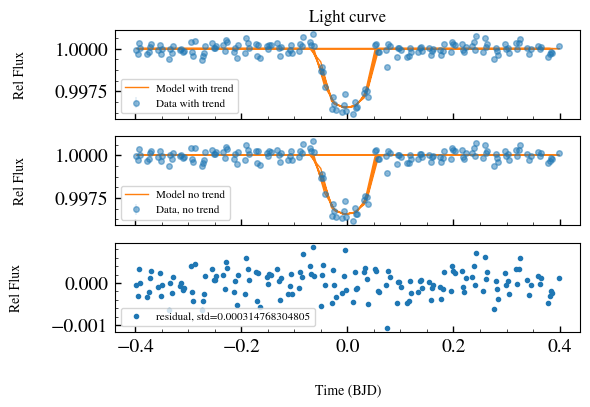

In [18]:
# Call the transit fitter.
# It does two main things:
# 1. Do an initial global optimization using PyDE
# 2. Do an MCMC run around the global minimum
TF()

Plotting chains


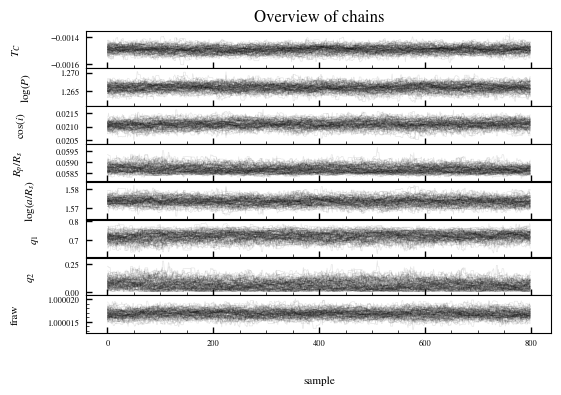

In [19]:
# Plot the chains, very useful for diagnostics. Check first with burn=0, to see if there are burn-in effects
TF.plot_chains(burn=200)

Plotting cornerplot


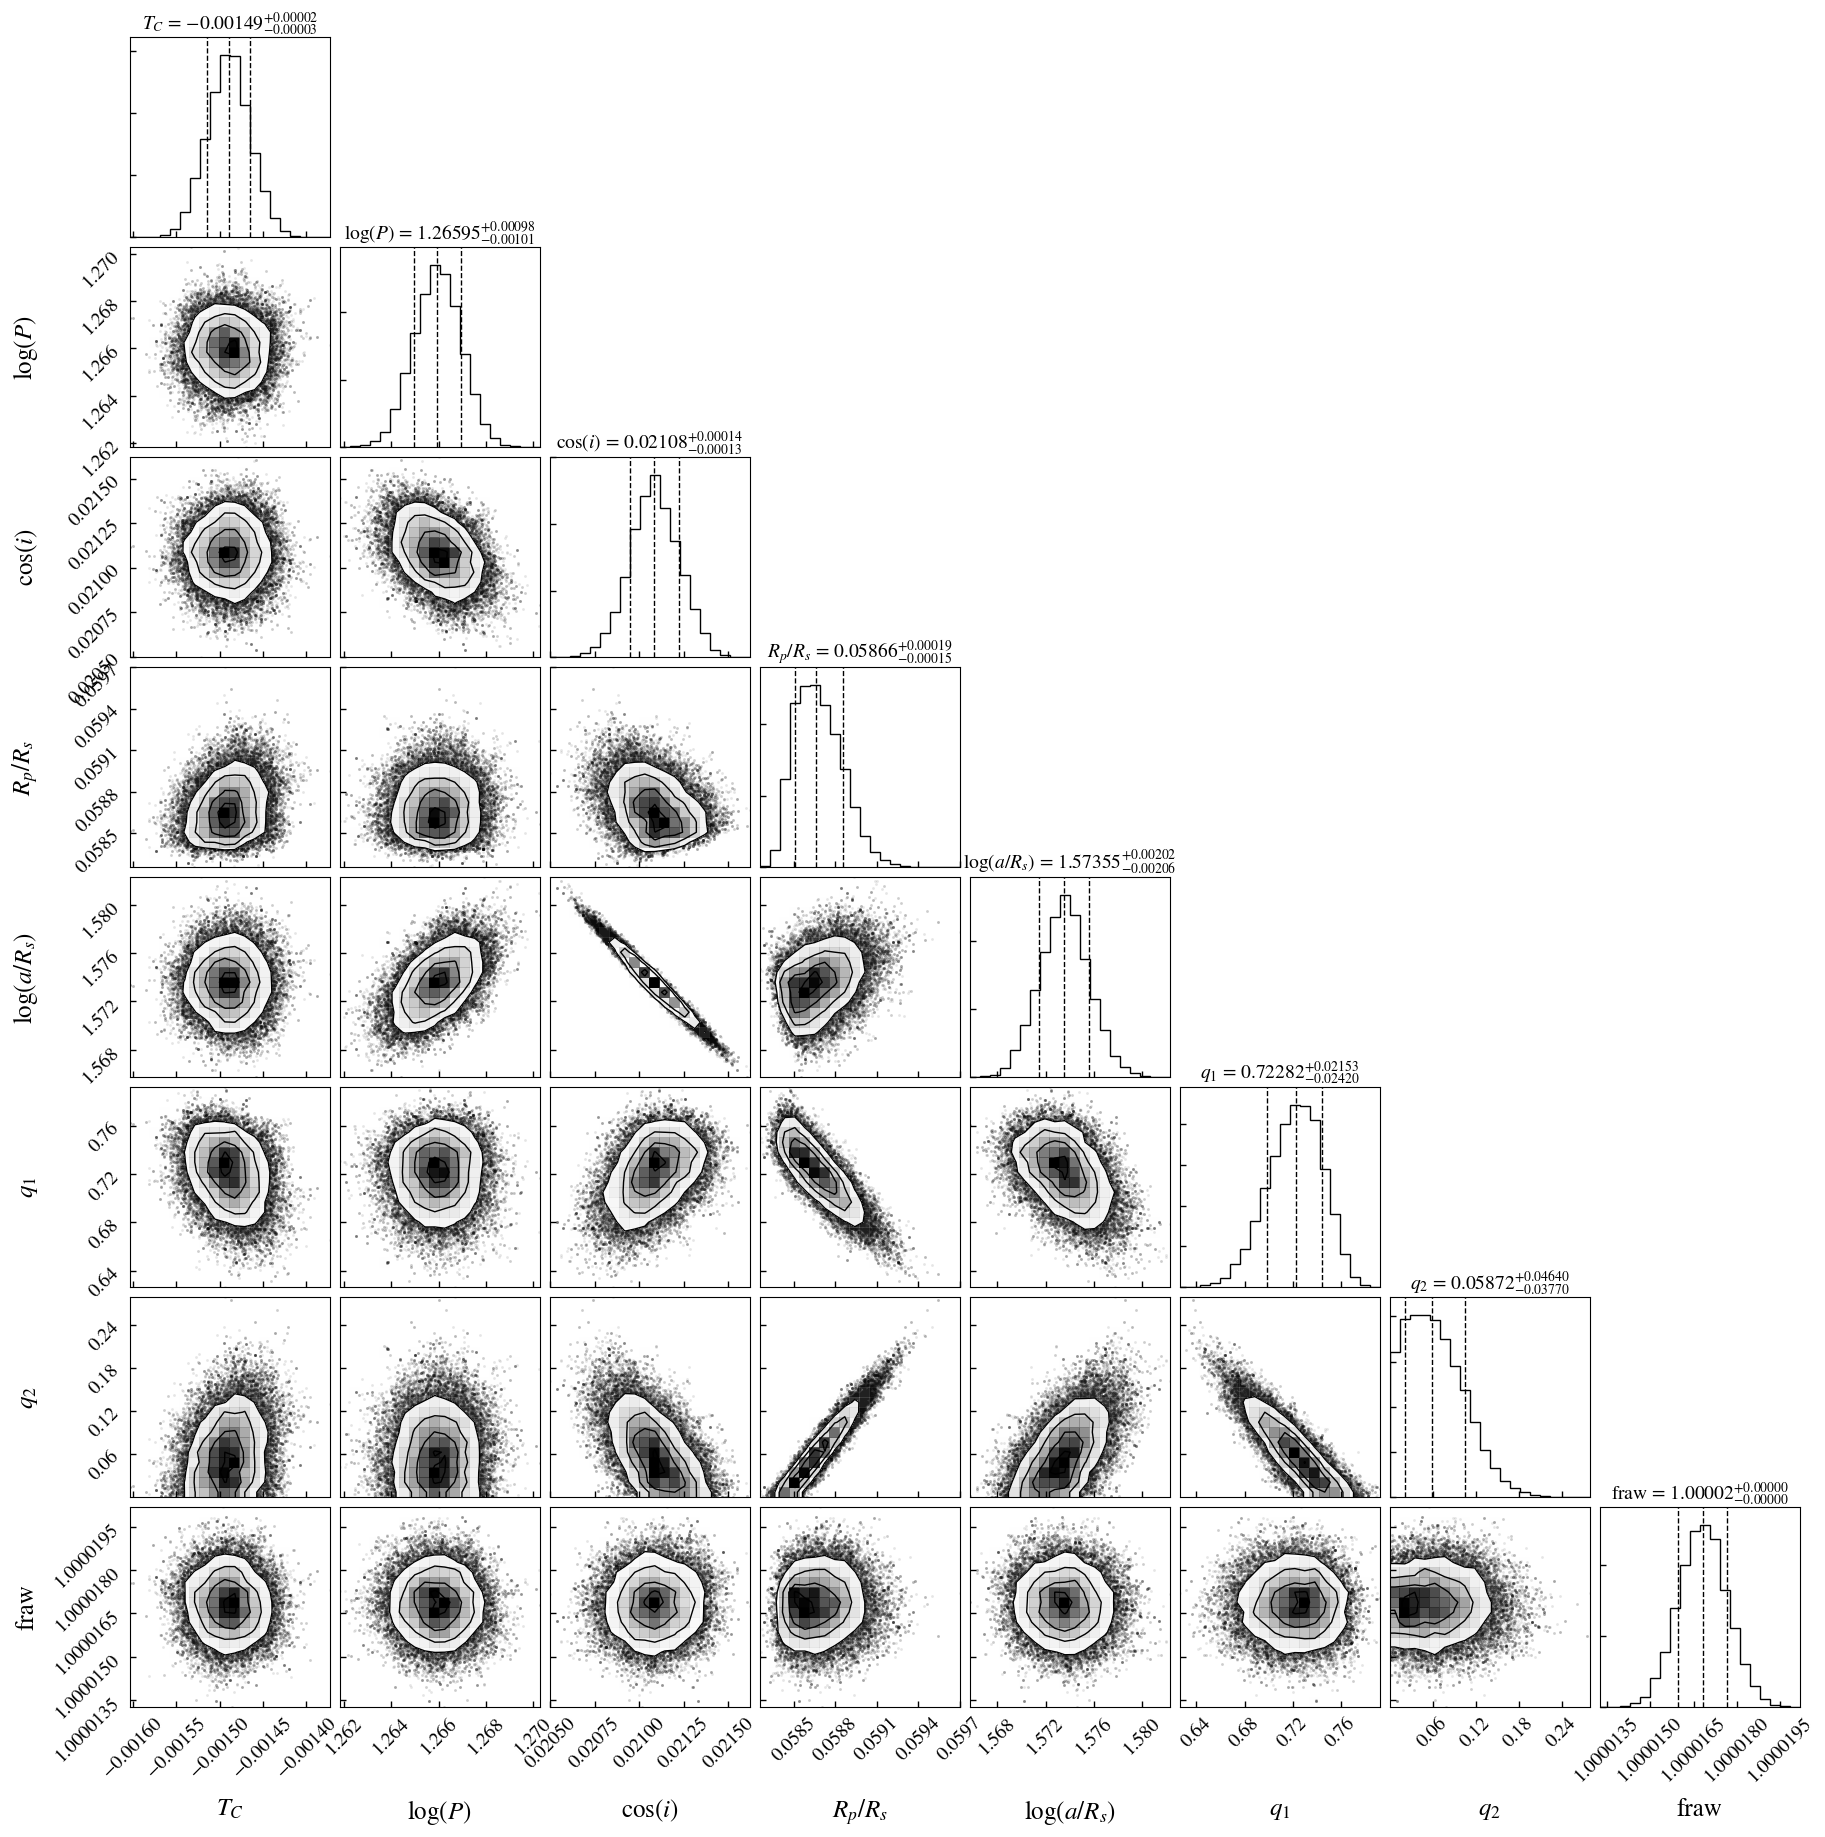

In [20]:
# Plot a corner plot
# 
TF.plot_corner(burn=200,show_titles=True)

In [21]:
# Get the planet parameters
TF.get_transit_parameters(burn=0,thin=1,st_rad=0.9,st_raderr1=0.01,st_teff=4000.,st_teff_err1=50.)

Assuming
('R_s:', 0.9, '+-', 0.01)
('Teff:', 4000.0, '+-', 50.0)
16


,medvals,minus,plus,values,Labels,Description
0,-0.001487,0.000026,0.000027,$-0.001487_{-0.00003}^{+0.00003}$,$T_{0}$ $(\mathrm{BJD_{TDB}})$,Transit Midpoint
1,18.442768,0.041494,0.043082,$18.443_{-0.041}^{+0.043}$,$P$ (days),Orbital period
2,0.058701,0.000179,0.000242,$0.0587_{-0.00018}^{+0.00024}$,$R_p/R_*$,Radius ratio
3,5.764101,0.067045,0.068481,$5.764_{-0.067}^{+0.068}$,$R_p (R_\oplus)$,Planet radius
4,0.514242,0.005981,0.006110,$0.5142_{-0.0060}^{+0.0061}$,$R_p (R_J)$,Planet radius
5,0.003446,0.000021,0.000028,$0.003446_{-0.00002}^{+0.00003}$,$\delta$,Transit depth
6,37.481595,0.185571,0.197401,$37.48_{-0.19}^{+0.20}$,$a/R_*$,Normalized orbital radius
7,0.156854,0.001923,0.001925,$0.1569_{-0.0019}^{+0.0019}$,$a$ (AU),Semi-major axis
8,88.793048,0.008402,0.008838,$88.793_{-0.0084}^{+0.0088}$,$i$ $(^{\circ})$,Transit inclination
9,0.789485,0.001827,0.001733,$0.7895_{-0.0018}^{+0.0017}$,$b$,Impact parameter


In [22]:
# Get the posteriors
TF.df_post

,t0,per,RpRs,R_e,R_j,depth,aRs,aAU,inc,b,e,w,Teq,t14,tau,tS
0,-0.001264,18.393817,0.058838,5.735651,0.511704,0.003462,38.508742,0.160048,88.857861,0.767585,0.0,0.0,454.055022,0.110920,0.014049,9.195644
1,-0.001264,18.393817,0.058838,5.740727,0.512157,0.003462,38.508742,0.160190,88.857861,0.767585,0.0,0.0,460.683929,0.110920,0.014049,9.195644
2,-0.001264,18.393817,0.058838,5.907218,0.527011,0.003462,38.508742,0.164836,88.857861,0.767585,0.0,0.0,457.363999,0.110920,0.014049,9.195644
3,-0.001310,18.444880,0.059013,5.819085,0.519148,0.003483,38.277724,0.160925,88.840542,0.774549,0.0,0.0,450.784891,0.110804,0.014412,9.221130
4,-0.001310,18.444880,0.059013,5.771048,0.514862,0.003483,38.277724,0.159596,88.840542,0.774549,0.0,0.0,450.783458,0.110804,0.014412,9.221130
5,-0.001310,18.444880,0.059013,5.815946,0.518868,0.003483,38.277724,0.160838,88.840542,0.774549,0.0,0.0,450.048251,0.110804,0.014412,9.221130
6,-0.001337,18.471345,0.058823,5.911539,0.527396,0.003460,38.611601,0.165439,88.853015,0.772901,0.0,0.0,449.949220,0.110229,0.014214,9.234336
7,-0.001337,18.471345,0.058823,5.844724,0.521435,0.003460,38.611601,0.163569,88.853015,0.772901,0.0,0.0,458.314821,0.110229,0.014214,9.234336
8,-0.001337,18.471345,0.058823,5.778295,0.515509,0.003460,38.611601,0.161710,88.853015,0.772901,0.0,0.0,459.132417,0.110229,0.014214,9.234336
9,-0.001337,18.471345,0.058823,5.887033,0.525210,0.003460,38.611601,0.164753,88.853015,0.772901,0.0,0.0,458.340492,0.110229,0.014214,9.234336


In [23]:
# Example parameters
TF.lpf.ps.centers

[0.0, 1.2659351647919772, 0.017, 0.05500000000000001, 1.5, 0.5, 0.5, 1.0]

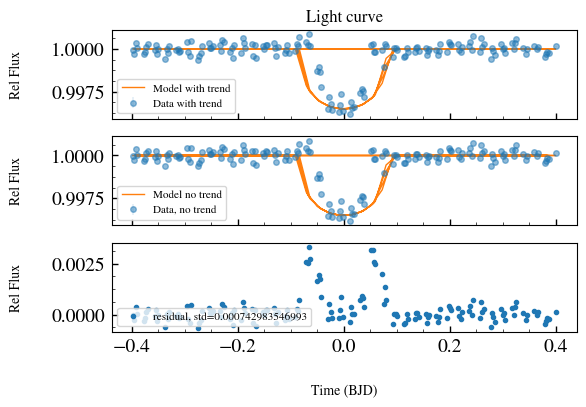

In [24]:
# Plot example parameters
# Code in an test example planet parameters
# This should not be a perfect fit, as we are just using some parameters by hand
pv = [0.0, 1.2659351647919772, 0.017, 0.055, 1.5, 0.5, 0.5, 1.0]
TF.plot_lc(pv)